# Image Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

zip_path = "/content/drive/MyDrive/cow.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/data")

print("Dataset extracted!")

Dataset extracted!


In [3]:
DATASET_PATH = "/content/data/Cows datasets"

In [4]:
import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import cv2

In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 0.01

In [6]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print(train_generator.class_indices)

Found 2596 images belonging to 3 classes.
Found 648 images belonging to 3 classes.
{'foot-and-mouth': 0, 'healthy': 1, 'lumpy': 2}


In [7]:
label_encoder = LabelEncoder()
label_encoder.fit(list(train_generator.class_indices.keys()))

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print("Saved classes:", label_encoder.classes_)

Saved classes: ['foot-and-mouth' 'healthy' 'lumpy']


In [8]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False   # Freeze layers for transfer learning

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(len(label_encoder.classes_), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [10]:
optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 89s 873ms/step - accuracy: 0.6702 - loss: 1.3194 - val_accuracy: 0.8796 - val_loss: 0.3369
Epoch 2/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 45s 555ms/step - accuracy: 0.8200 - loss: 0.6192 - val_accuracy: 0.8657 - val_loss: 0.4761
Epoch 3/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 46s 555ms/step - accuracy: 0.8528 - loss: 0.4995 - val_accuracy: 0.8796 - val_loss: 0.4131
Epoch 4/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 44s 542ms/step - accuracy: 0.8735 - loss: 0.4666 - val_accuracy: 0.8611 - val_loss: 0.5122
Epoch 5/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 46s 563ms/step - accuracy: 0.8382 - loss: 0.6206 - val_accuracy: 0.9151 - val_loss: 0.3071
Epoch 6/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 45s 544ms/step - accuracy: 0.8622 - loss: 0.5123 - val_accuracy: 0.8904 - val_loss: 0.3688
Epoch 7/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 45s 546ms/step - accuracy: 0.8632 - loss: 0.5658 - val_accuracy: 0.8457 - val_loss: 0.7844
Epoch 8/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 46s 553ms/step - accuracy: 0.8559 - loss: 0.6584 - val_accu

In [12]:
model.save("cattle_disease_model.h5")
print("Model saved successfully!")

Model saved successfully!


In [13]:
model = tf.keras.models.load_model("cattle_disease_model.h5")

with open("label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

In [14]:
def predict_and_show(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, IMG_SIZE)
    img_norm = img_resized.astype("float32") / 255.0
    img_input = np.expand_dims(img_norm, axis=0)

    preds = model.predict(img_input)[0]
    class_idx = np.argmax(preds)
    class_name = label_encoder.inverse_transform([class_idx])[0]
    confidence = float(preds[class_idx])

    plt.imshow(img_rgb)
    plt.title(f"{class_name} ({confidence:.2f})")
    plt.axis("off")
    plt.show()

    print("Prediction:", class_name)
    print("Confidence:", confidence)


Testing: C1.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


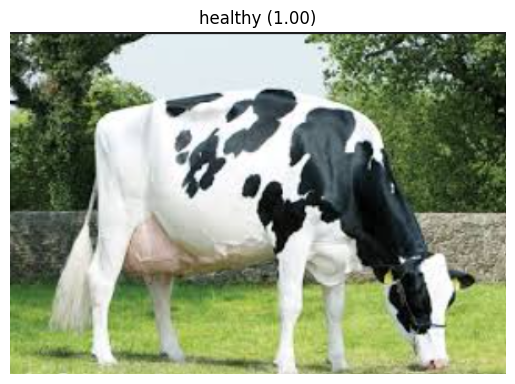

Prediction: healthy
Confidence: 1.0

Testing: C2.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


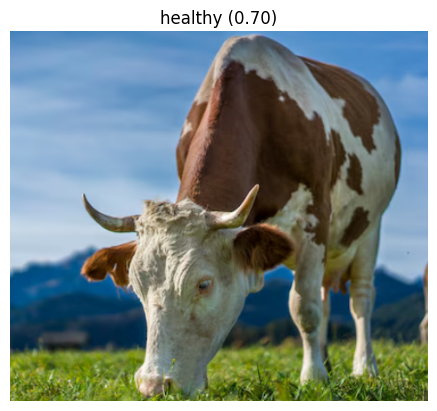

Prediction: healthy
Confidence: 0.6967712044715881

Testing: C3.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


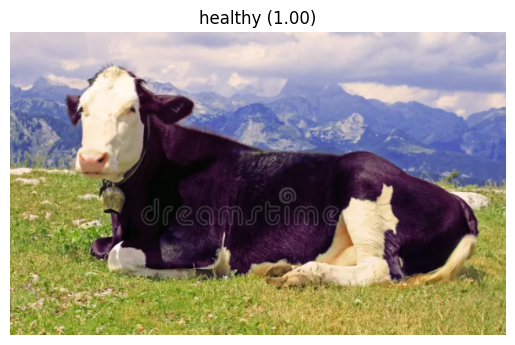

Prediction: healthy
Confidence: 1.0

Testing: C4.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


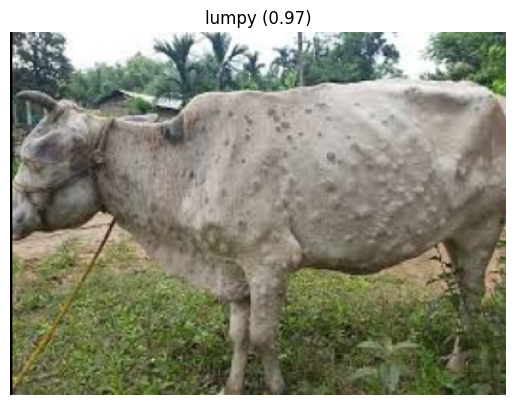

Prediction: lumpy
Confidence: 0.9685893058776855

Testing: C5.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


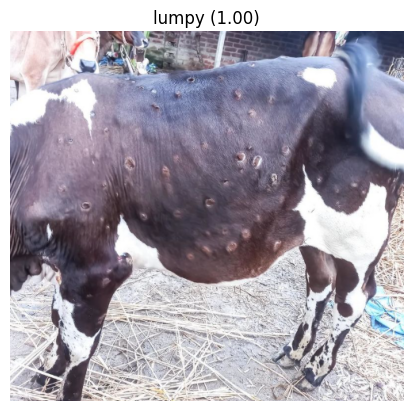

Prediction: lumpy
Confidence: 0.9999619722366333

Testing: C6.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


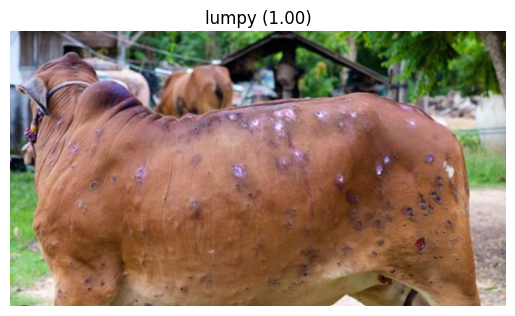

Prediction: lumpy
Confidence: 1.0

Testing: C7.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


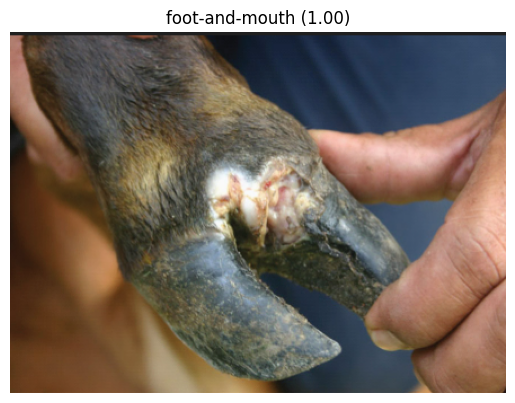

Prediction: foot-and-mouth
Confidence: 1.0

Testing: C10_H.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


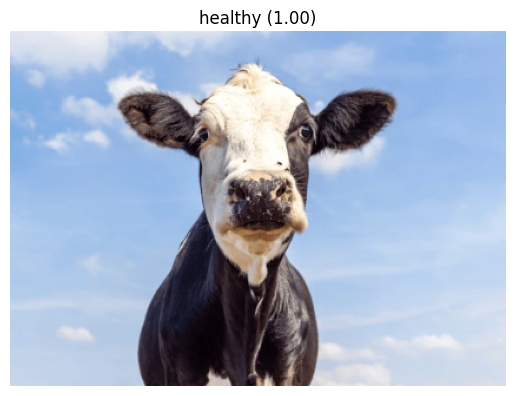

Prediction: healthy
Confidence: 0.9999948740005493

Testing: C8.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


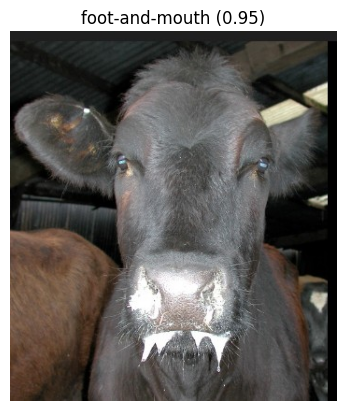

Prediction: foot-and-mouth
Confidence: 0.9515096545219421

Testing: C11.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


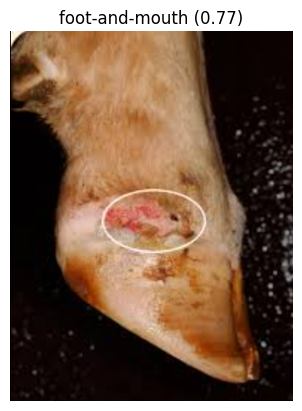

Prediction: foot-and-mouth
Confidence: 0.7709044218063354

Testing: C9.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


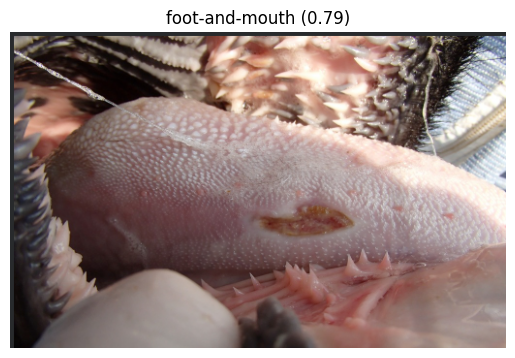

Prediction: foot-and-mouth
Confidence: 0.7907950282096863

Testing: C12.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


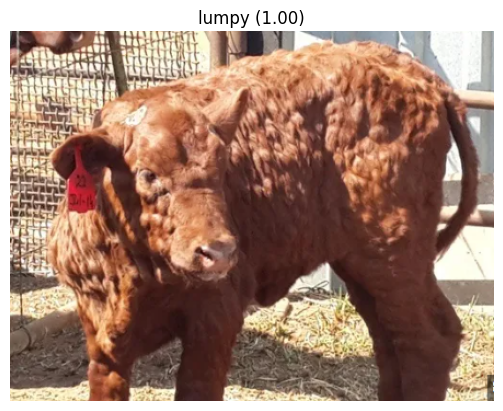

Prediction: lumpy
Confidence: 0.9999370574951172

Testing: C13.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


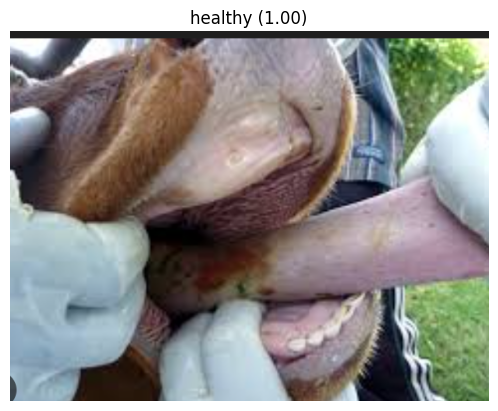

Prediction: healthy
Confidence: 0.9991078972816467

Testing: C14.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


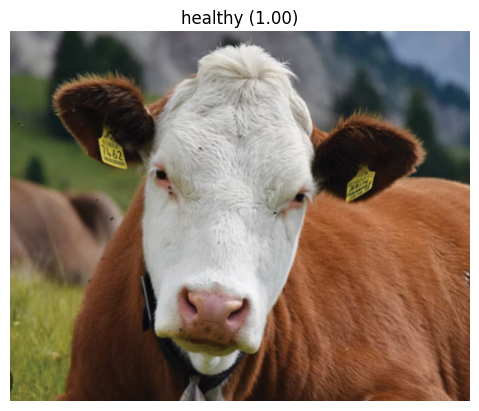

Prediction: healthy
Confidence: 1.0

Testing: C15.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


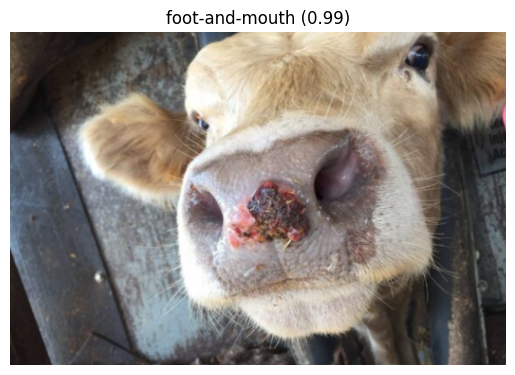

Prediction: foot-and-mouth
Confidence: 0.9850134253501892


In [16]:
test_folder = "/content/drive/MyDrive/Cow"

for fname in os.listdir(test_folder):
    if fname.lower().endswith((".jpg",".jpeg",".png")):
        print("\nTesting:", fname)
        predict_and_show(os.path.join(test_folder, fname))